John Klein: 10044346  
Kristian Rehn: 10043938  

In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from PIL import Image
from torch.utils.data import TensorDataset
import torchvision
import torch.nn as nn
from torch.optim import Adam

from torchvision import transforms, datasets
from torch.utils.data import Subset

from torchvision.datasets import CIFAR10
from tqdm import tqdm

## Prepare Datasets

In [181]:
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '/content/data'
train_dataset = CIFAR10(path, transform=transform, download=True)
test_dataset  = CIFAR10(path, transform=transform, download=True)

# create train and testt dataloaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [182]:
def create_dog_cat_datasets(dataloader, batch_size=32, shuffle=True):

    cat_dog_images = []
    cat_dog_labels = []

    for images, labels in dataloader:
        # Find labels: 3 (cat) or 5 (dog)
        mask = (labels == 3) | (labels == 5)
        filtered_images = images[mask]
        filtered_labels = labels[mask]

        # Relabel cats as 0 and dogs as 1
        filtered_labels = (filtered_labels == 5).long()

        cat_dog_images.append(filtered_images)
        cat_dog_labels.append(filtered_labels)

    final_images = torch.cat(cat_dog_images, dim=0)
    final_labels = torch.cat(cat_dog_labels, dim=0)

    # Create a TensorDataset and DataLoader with the filtered data
    dataset = TensorDataset(final_images, final_labels)
    filtered_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return filtered_dataloader


In [183]:
train_dog_cat_loader = create_dog_cat_datasets(train_loader)
test_dog_cat_loader = create_dog_cat_datasets(test_loader)

In [184]:
def display_examples(train_dog_cat_loader, num_rows=5, num_cols=5, class_names=None):
  dataiter = iter(train_dog_cat_loader)
  images, labels = next(dataiter)

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  axes = axes.flatten()

  for i in range(num_rows * num_cols):
    image = images[i].numpy().transpose((1, 2, 0))
    label = labels[i].item()

    axes[i].imshow(image)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

    if class_names:
      axes[i].set_title(class_names[label])
    else:
      axes[i].set_title(f"Class: {label}")

  plt.tight_layout()
  plt.show()

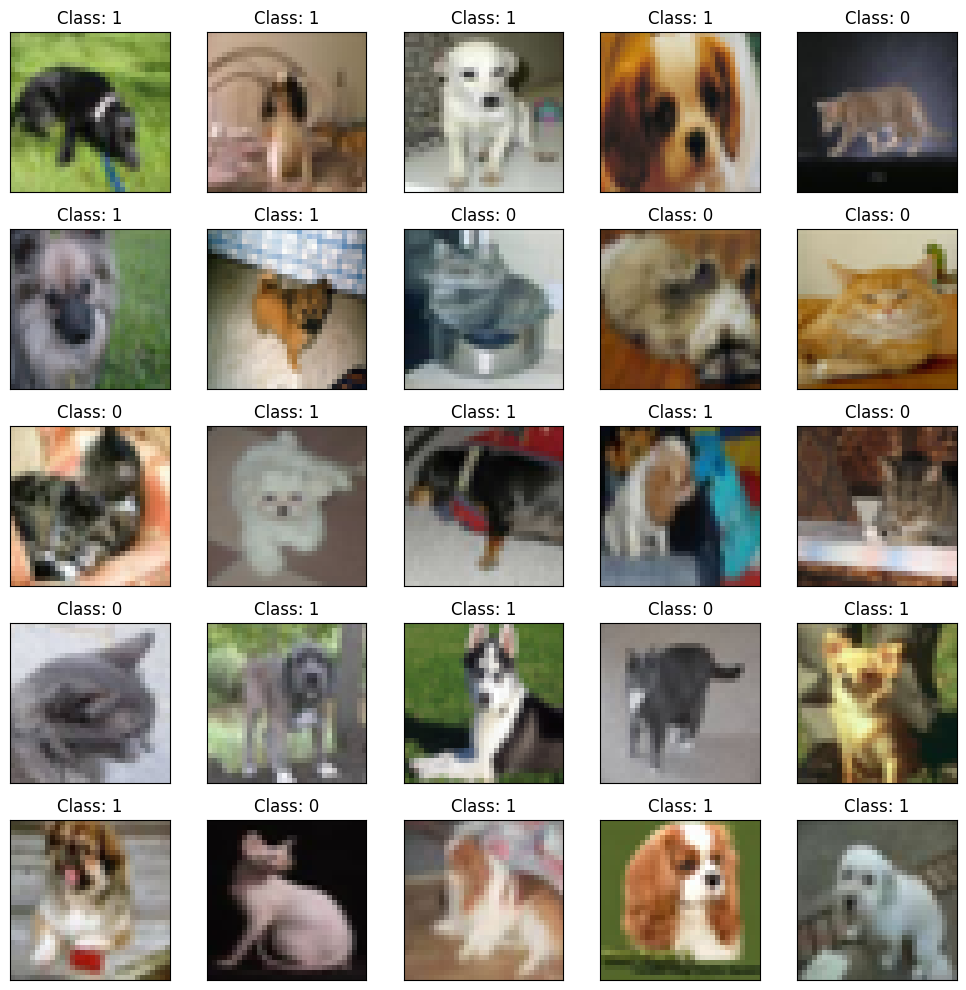

In [185]:
display_examples(train_dog_cat_loader,num_rows=5, num_cols=5)

# Task 1

In [186]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64* 64,  64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [187]:
model = CNN()

optimizer = Adam(model.parameters(), lr=0.001)

criterion = nn.BCELoss()

In [188]:
import torch
import torch.nn as nn

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dog_cat_loader):
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dog_cat_loader)}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for images, labels in train_dog_cat_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            predictions = (outputs > 0.5).float()  # Set trashhold ti 0.5
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')
    model.train()

# Evaluation on test set
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_dog_cat_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images).squeeze()
        predictions = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


Epoch [1/10], Step [100/313], Loss: 0.6926
Epoch [1/10], Step [200/313], Loss: 0.6050
Epoch [1/10], Step [300/313], Loss: 0.6515
Validation Accuracy: 63.01%
Epoch [2/10], Step [100/313], Loss: 0.6293
Epoch [2/10], Step [200/313], Loss: 0.5225
Epoch [2/10], Step [300/313], Loss: 0.6874
Validation Accuracy: 68.69%
Epoch [3/10], Step [100/313], Loss: 0.6321
Epoch [3/10], Step [200/313], Loss: 0.6617
Epoch [3/10], Step [300/313], Loss: 0.4993
Validation Accuracy: 73.58%
Epoch [4/10], Step [100/313], Loss: 0.3892
Epoch [4/10], Step [200/313], Loss: 0.4352
Epoch [4/10], Step [300/313], Loss: 0.5620
Validation Accuracy: 75.02%
Epoch [5/10], Step [100/313], Loss: 0.7478
Epoch [5/10], Step [200/313], Loss: 0.3767
Epoch [5/10], Step [300/313], Loss: 0.5501
Validation Accuracy: 76.92%
Epoch [6/10], Step [100/313], Loss: 0.3361
Epoch [6/10], Step [200/313], Loss: 0.3737
Epoch [6/10], Step [300/313], Loss: 0.5170
Validation Accuracy: 79.71%
Epoch [7/10], Step [100/313], Loss: 0.4972
Epoch [7/10], S

In [163]:
def create_datasets_without_dogs_cats(dataloader, batch_size=32, shuffle=True):

    filtered_images = []
    filtered_labels = []

    for images, labels in dataloader:
        # Find labels that are not 3 (cats) or 5 (dogs)
        mask = (labels != 3) & (labels != 5)

        filtered_images.append(images[mask])
        filtered_labels.append(labels[mask])

    final_images = torch.cat(filtered_images, dim=0)
    final_labels = torch.cat(filtered_labels, dim=0)

    # relabeling to 1-7
    label_mapping = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7}
    relabeled = torch.tensor([label_mapping[label.item()] for label in final_labels])


    dataset = TensorDataset(final_images, relabeled)
    filtered_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return filtered_dataloader

In [164]:
train_dataset_without_dogs_cats = create_datasets_without_dogs_cats(train_loader)
test_dataset_without_dogs_cats = create_datasets_without_dogs_cats(test_loader)

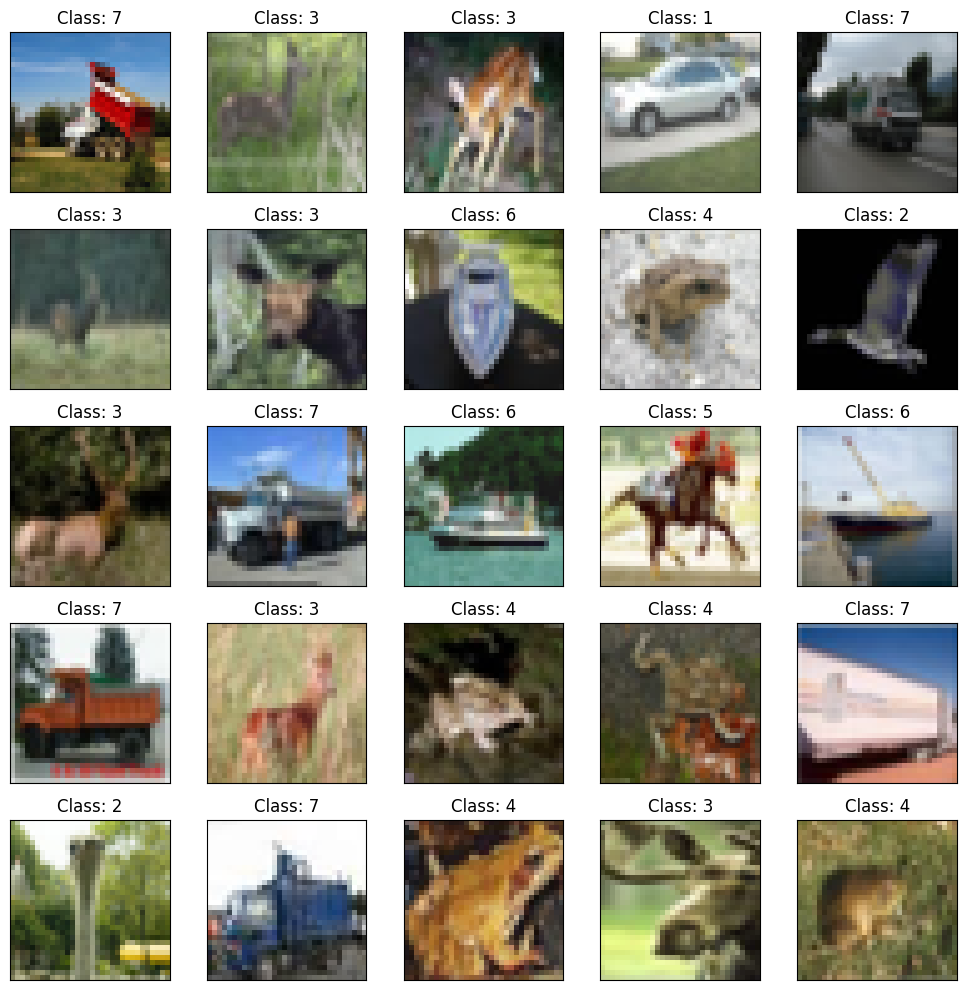

In [165]:
display_examples(train_dataset_without_dogs_cats)

# Task 2

In [166]:
# Define the Autoencoder Architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




In [167]:
def add_noise(images, noise_factor=0.1):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

In [169]:
def train_autoencoder(model, dataloader, num_epochs=10, learning_rate=1e-3, noise_factor=0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, _ in dataloader:
            images = images.to(device)
            noisy_images = add_noise(images, noise_factor).to(device)

            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    print("Finished Training")
    return model


Epoch [1/10], Loss: 0.0089
Epoch [2/10], Loss: 0.0051
Epoch [3/10], Loss: 0.0046
Epoch [4/10], Loss: 0.0043
Epoch [5/10], Loss: 0.0042
Epoch [6/10], Loss: 0.0041
Epoch [7/10], Loss: 0.0040
Epoch [8/10], Loss: 0.0039
Epoch [9/10], Loss: 0.0039
Epoch [10/10], Loss: 0.0039
Finished Training


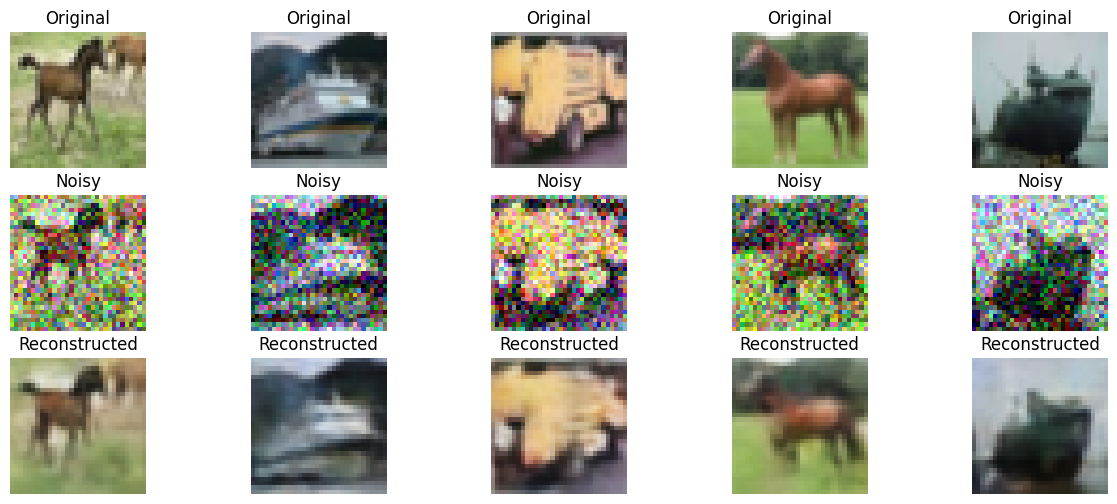

In [170]:
autoencoder = DenoisingAutoencoder()

trained_autoencoder = train_autoencoder(autoencoder, train_dataset_without_dogs_cats, num_epochs=10, learning_rate=1e-3, noise_factor=0.2)

# Visualize autoencoder
def visualize_reconstruction(model, dataloader, noise_factor=0.2):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    images, _ = next(iter(dataloader))
    images = images.to(device)
    noisy_images = add_noise(images, noise_factor).to(device)
    with torch.no_grad():
        reconstructed = model(noisy_images)

    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    noisy_images = noisy_images.cpu().numpy().transpose(0, 2, 3, 1)
    reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)

    fig, axs = plt.subplots(3, 5, figsize=(15, 6))
    for i in range(5):
        axs[0, i].imshow(images[i])
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')
        axs[1, i].imshow(noisy_images[i])
        axs[1, i].set_title("Noisy")
        axs[1, i].axis('off')
        axs[2, i].imshow(reconstructed[i])
        axs[2, i].set_title("Reconstructed")
        axs[2, i].axis('off')
    plt.show()

visualize_reconstruction(trained_autoencoder, train_dataset_without_dogs_cats, noise_factor=0.2)

# Task 3 (4)

In [171]:
class FineTunedModel(nn.Module):
    def __init__(self, pre_trained_autoencoder):
        super(FineTunedModel, self).__init__()
        self.encoder = pre_trained_autoencoder.encoder
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [172]:
def fine_tune_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # Validation with test_loader
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images).squeeze()
                predictions = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Validation Accuracy: {accuracy:.2f}%')

    print("Finished Fine-Tuning")
    return model

In [175]:
autoencoder = trained_autoencoder

fine_tuned_model = FineTunedModel(autoencoder)

In [176]:
fine_tuned_model = fine_tune_model(fine_tuned_model, train_dog_cat_loader, test_dog_cat_loader, num_epochs=20)

Epoch [1/20], Loss: 0.6249
Validation Accuracy: 70.63%
Epoch [2/20], Loss: 0.5701
Validation Accuracy: 71.28%
Epoch [3/20], Loss: 0.5449
Validation Accuracy: 73.72%
Epoch [4/20], Loss: 0.5288
Validation Accuracy: 76.24%
Epoch [5/20], Loss: 0.5114
Validation Accuracy: 76.59%
Epoch [6/20], Loss: 0.4971
Validation Accuracy: 76.37%
Epoch [7/20], Loss: 0.4846
Validation Accuracy: 78.42%
Epoch [8/20], Loss: 0.4739
Validation Accuracy: 78.74%
Epoch [9/20], Loss: 0.4611
Validation Accuracy: 80.45%
Epoch [10/20], Loss: 0.4532
Validation Accuracy: 79.99%
Epoch [11/20], Loss: 0.4396
Validation Accuracy: 80.64%
Epoch [12/20], Loss: 0.4286
Validation Accuracy: 82.55%
Epoch [13/20], Loss: 0.4200
Validation Accuracy: 79.51%
Epoch [14/20], Loss: 0.4088
Validation Accuracy: 83.49%
Epoch [15/20], Loss: 0.3985
Validation Accuracy: 82.29%
Epoch [16/20], Loss: 0.3900
Validation Accuracy: 84.36%
Epoch [17/20], Loss: 0.3766
Validation Accuracy: 84.85%
Epoch [18/20], Loss: 0.3689
Validation Accuracy: 86.44%
E

In [179]:
with torch.no_grad():
            fine_tuned_model.eval()
            correct = 0
            total = 0
            for images, labels in test_dog_cat_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = fine_tuned_model(images).squeeze()
                predictions = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predictions == labels).sum().item()

            accuracy = 100 * correct / total
            print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 86.94%


# Task 4


When using less data the training takes longer, with around 17 to 20 epochs the result is similar to the CNN, with the whole Dataset. I think this is quite obviouse, because the task is very simple and doesnt need much training. Therefor the pre-training cant benefit as well as it does at complex tasks. The pretrained model starts a little bit better, because of the pretraining. A CNN starts with the first few examples at around 50% (which is equivalent to random choice).

###Note:
   I plottet the values this way, bacause i dont want to rerun the cells, to prevent getting other more worse results.

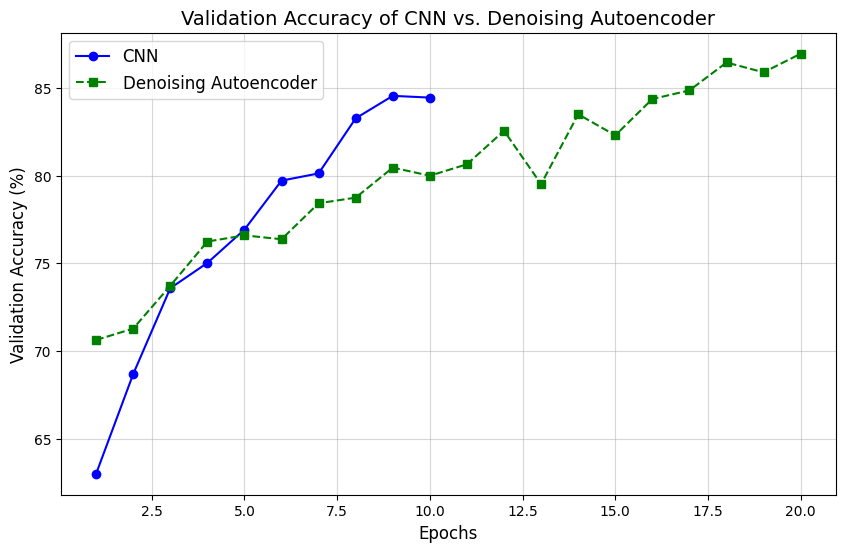

In [3]:
# CNN Validation Accuracy
epochs_cnn = list(range(1, 11))
accuracy_cnn = [
    63.01, 68.69, 73.58, 75.02, 76.92, 79.71, 80.12, 83.26, 84.54, 84.44
]
#Auto Encoder Accuracy
epochs_ae = list(range(1, 21))
accuracy_ae = [
    70.63, 71.28, 73.72, 76.24, 76.59, 76.37, 78.42, 78.74, 80.45, 79.99,
    80.64, 82.55, 79.51, 83.49, 82.29, 84.36, 84.85, 86.44, 85.88, 86.94
]

plt.figure(figsize=(10, 6))
plt.plot(epochs_cnn, accuracy_cnn, label='CNN', marker='o', linestyle='-', color='blue')
plt.plot(epochs_ae, accuracy_ae, label='Denoising Autoencoder', marker='s', linestyle='--', color='green')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Validation Accuracy of CNN vs. Denoising Autoencoder', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()
